In [1]:
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.append("/Users/Trevor1/Desktop/git/CIV_Distance/")
from CIVfunctions import project,CIV_distance

In [46]:
def plot_contour(xdata, ydata, c="k", nlevels=3, ax=None, label=""):
    if ax is None:
        ax = plt.gca()
    xmin, xmax = xdata.min(), xdata.max()
    ymin, ymax = ydata.min(), ydata.max()
    X, Y = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([xdata, ydata])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    
    #ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c)
    levels = ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c).levels
    
    for i in range(len(xdata)):
        #These are the indices of the ith's point location in Z (the density estimation) - probably the only tricky part about this
        xind = abs(X[:,0] - positions[0, abs(positions[0] - xdata[i]).argmin()]).argmin()
        yind = abs(Y[0,:] - positions[1, abs(positions[1] - ydata[i]).argmin()]).argmin()
        
        if Z[xind,yind] < levels[1]: #Plot the scatter point if it's below outermost contour level
            ax.scatter(xdata[i], ydata[i], color=c, s=10)#, label=label) #label only once

In [3]:
!ls

AllXRayData.071221.fits
AllXRayData.fits
CIVDistBokehGTR.070521.html
CIVDistBokehGTR.html
CIVDistBokehGTR_logCIVEW.html
CIVDistsBokehGTR.070521.ipynb
CIVDistsBokehGTR_trevor.ipynb
CIV_amy_scaled_linear.npy
CIV_amy_scaled_log.npy
gamma_daox_diagonal_corrs-Copy1.ipynb
gamma_daox_diagonal_corrs.ipynb
gamma_daox_diagonal_corrs_shiftdaox.ipynb
gamma_vs_daox


In [4]:
df = Table.read('AllXRayData.071221.fits', format='fits')
dat = df.to_pandas()
dat.head()

,SDSS,LOGEDD_RATIO,Gamma,f2keV_ergs,L2500,Alpha_ox,Delta_Alpha_ox,New_Delta_Alpha_ox,Delg-i,Timlin_CIV_EQW,...,Old_redshift,Redshifts,HeII_EQW,LOGBH,Data_source,Clean,RA,DEC,Nardini_Sample,EV1
0,b'SDSSJ123003.80+162308.2',-0.76,1.85810,-31.759840,31.096001,-1.617769,-0.002665,-0.039064,0.116000,NaN,...,NaN,2.37464,0.393129,9.72,4,False,187.515859,16.385636,False,NaN
1,b'150313.62+575151.5 ',-0.42,2.20000,-30.648514,31.443727,-1.622615,0.061687,0.022610,-0.071669,NaN,...,1.721368,NaN,NaN,9.59,1,False,225.806747,57.864326,False,NaN
2,b'SDSSJ092513.03+363748.5',NaN,2.13456,-32.024640,30.580400,-1.456527,0.055972,0.023543,0.042000,NaN,...,NaN,2.77289,2.818198,NaN,4,False,141.304324,36.630149,False,NaN
3,b'SDSSJ135320.48+400809.8',-0.66,2.89310,-31.597590,30.796700,-1.584457,-0.028914,-0.063009,-0.095000,NaN,...,NaN,1.67258,0.651358,9.13,4,False,208.335375,40.136058,False,NaN
4,b'103151.76-013557.2 ',NaN,1.60000,-31.154761,30.838674,-1.499198,0.064698,0.030281,-0.141138,NaN,...,2.295000,2.29601,3.535803,NaN,1,False,157.965674,-1.599229,False,NaN


In [5]:
dat.shape, dat["Clean"].values.sum()

((5682, 23), 1378)

In [9]:
#Take the clean objects that have available measurements
blue = dat["CIV_blue"].values
gamma = dat["Gamma"].values
daox  = dat["Delta_Alpha_ox"].values
clean = dat["Clean"].values
dat = dat[~np.isnan(blue)&~np.isnan(daox)&~np.isinf(gamma)&clean]

In [10]:
dat.shape

(1067, 23)

In [11]:
#Define vars in cut dataframe
gamma = dat["Gamma"].values
daox  = dat["Delta_Alpha_ox"].values
blue = dat["CIV_blue"].values
ew   = dat["CIV_EW"].values
logEW= np.log10(ew)
c4data = np.array([blue, logEW]).T
c4fit = np.load("/Users/Trevor1/Desktop/git/CIV_Distance/data/bestfit.npy")
CIVdist = CIV_distance(c4data, c4fit, step=10, path="/Users/Trevor1/Desktop/git/CIV_Distance/")

In [12]:
np.isnan(daox).sum()

0

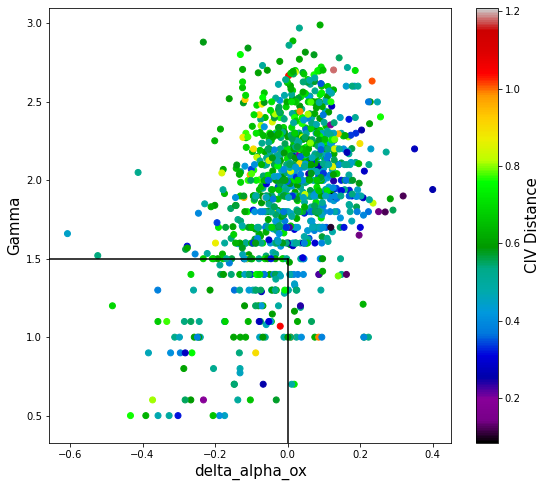

In [14]:
fig = plt.figure(figsize=(9,8))
plt.scatter(daox, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.show()

We don't know the absorption track for each individual object.  Instead we'll compute the median value of $\Delta\alpha_{ox}$ in bins of $\Gamma$

In [15]:
np.linspace(min(gamma), max(gamma), 10)

array([0.5       , 0.88228334, 1.26456669, 1.64685003, 2.02913337,
       2.41141672, 2.79370006, 3.1759834 , 3.55826675, 3.94055009])

In [16]:
gamma_bins  = np.linspace(min(gamma), 3, 12)
median_daox = []

for i in range(len(gamma_bins)-1):
    daox_med = np.nanmedian(daox[((gamma>=gamma_bins[i])&(gamma<gamma_bins[i+1]))])
    median_daox.append(daox_med)

In [17]:
gamma_bins_plot = gamma_bins[:-1] + ((gamma_bins[1]-gamma_bins[0])/2)

In [18]:
len(gamma_bins_plot), len(median_daox)

(11, 11)

In [19]:
median_daox

[-0.1967408368665,
 -0.263800785803,
 -0.064886904851949,
 -0.040251074099100004,
 -0.049507589372849506,
 0.0062864079369149995,
 0.02487117838169202,
 0.042076987072753536,
 0.039517185362548446,
 0.0526699538970945,
 0.023572225512085154]

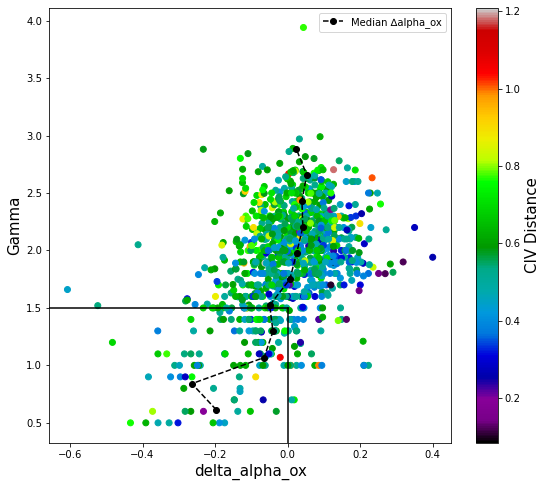

In [20]:
fig = plt.figure(figsize=(9,8))
plt.scatter(daox, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(median_daox, gamma_bins_plot, "--o", color="k", label="Median ∆alpha_ox")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.legend(loc="best")
plt.show()

Want to loop through each data point

1) Check which gamma it's closest to in the plot; save index

2) Save $\Delta\alpha_{ox}$ corresponding to the given gamma (based on the median)

3) Shift $\Delta\alpha_{ox}$ for that object by minus that much

In [29]:
daox_new = []
for i in range(len(gamma)):
    ind = abs(gamma[i]-gamma_bins_plot).argmin()
    gamma_close = gamma_bins_plot[ind]
    daox_close = median_daox[ind]
    daox_new.append(daox[i]-daox_close)
daox_new = np.array(daox_new)

In [30]:
#Recompute median daox
median_daox_new = []
for i in range(len(gamma_bins)-1):
    daox_med = np.nanmedian(daox_new[((gamma>=gamma_bins[i])&(gamma<gamma_bins[i+1]))])
    median_daox_new.append(daox_med)

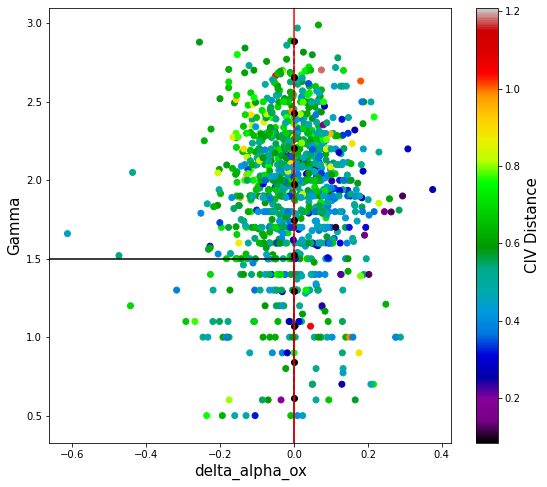

In [31]:
m,b = np.polyfit(median_daox_new[2:], gamma_bins_plot[2:], 1)
x = np.linspace(-0.6, 0.45, 10000)
y = m*x + b

fig = plt.figure(figsize=(9,8))
plt.scatter(daox_new, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(median_daox_new, gamma_bins_plot, "--o", color="k")
plt.plot(x,y,"-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.show()

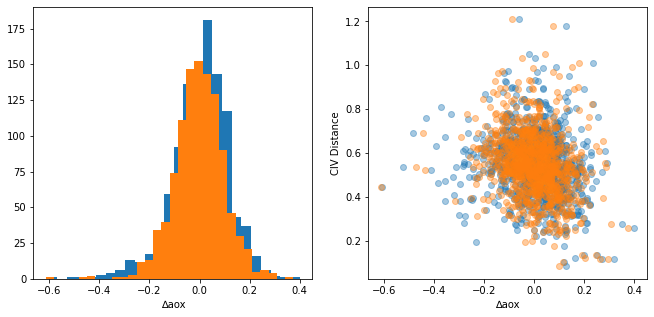

In [32]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))

ax1.hist(daox, bins="scott", label="Original ∆aox")
ax1.hist(daox_new, bins="scott", label="Median-gamma shifted ∆aox")
ax1.set_xlabel("∆aox")

ax2.scatter(daox, CIVdist, alpha=0.4, label="Original ∆aox")
ax2.scatter(daox_new, CIVdist, alpha=0.4, label="Median-gamma shifted ∆aox")
ax2.set_xlabel("∆aox")
ax2.set_ylabel("CIV Distance")

plt.show()

Reduced the spread, so just look at the new distribution,

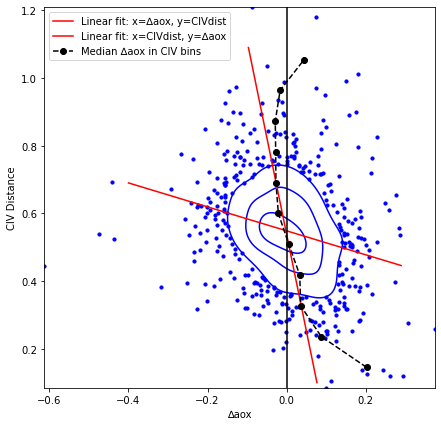

In [49]:
#See what a simple linear fit looks like - do two versions, flipping the axes
m1,b1 = np.polyfit(daox_new, CIVdist, 1)
x1 = np.arange(-0.4, 0.3, 0.01)
y1 = m1*x1 + b1
fit_lin1 = np.array([x1,y1]).T

m2,b2 = np.polyfit(CIVdist, daox_new, 1)
x2 = np.arange(0.1, 1.1, 0.01)
y2 = m2*x2 + b2
fit_lin2 = np.array([y2,x2]).T

#Also get the median ∆aox in each CIV bin
CIVdist_bins  = np.linspace(0.1, 1.1, 12)
median_daox_new_civ = []
for i in range(len(CIVdist_bins)-1):
    daox_new_med = np.median(daox_new[((CIVdist>=CIVdist_bins[i])&(CIVdist<CIVdist_bins[i+1]))])
    median_daox_new_civ.append(daox_new_med)
CIVdist_bins_plot = CIVdist_bins[:-1] + ((CIVdist_bins[1]-CIVdist_bins[0])/2)



fig, ax1 = plt.subplots(figsize=(7,7))

#ax1.scatter(daox_new, CIVdist, alpha=0.4, label="Median-gamma shifted ∆aox")
plot_contour(daox_new, CIVdist, c="b", label="Median-gamma shifted ∆aox")
ax1.plot(fit_lin1[:,0], fit_lin1[:,1], "-r", label="Linear fit: x=∆aox, y=CIVdist")
ax1.plot(fit_lin2[:,0], fit_lin2[:,1], "-r", label="Linear fit: x=CIVdist, y=∆aox")
ax1.plot(median_daox_new_civ, CIVdist_bins_plot, "--o", c="k", label="Median ∆aox in CIV bins")

xlims, ylims = ax1.get_xlim(), ax1.get_ylim()
ax1.plot([0.0,0.0], [0.0,1.4], "-k")
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)

ax1.set_xlabel("∆aox")
ax1.set_ylabel("CIV Distance")
ax1.legend(loc="best")

plt.show()

We could also bisect the two best-fit lines (as was done in ``gamma_daox_diagonal_corrs_shiftdaox.ipynb``) to blend the two linear fits, but for now should probably just shift according to the median. 


Loop through each data point above

1) Get the point in ``CIVdist_bins_plot`` that is closest to the CIV distance of the current point; save index

2) Get the corresponding point in ``median_daox_new_civ``

3) Shift daox by that much

In [50]:
CIVdist_bins_plot

array([0.14545455, 0.23636364, 0.32727273, 0.41818182, 0.50909091,
       0.6       , 0.69090909, 0.78181818, 0.87272727, 0.96363636,
       1.05454545])

In [51]:
daox_new2 = []
for i in range(len(CIVdist)):
    ind = abs(CIVdist_bins_plot-CIVdist[i]).argmin()
    #ind = abs(y_med-CIVdist[i]).argmin()
    dist_shift = median_daox_new_civ[ind]
    daox_new2.append(daox_new[i]-dist_shift)
daox_new2 = np.array(daox_new2) 

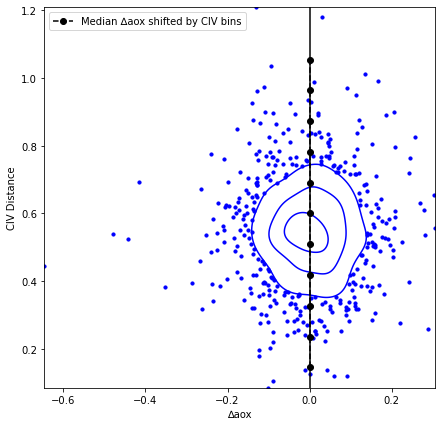

In [52]:
#get the median ∆aox in each CIV bin again
median_daox_new2_civ = []
for i in range(len(CIVdist_bins)-1):
    daox_new_med = np.median(daox_new2[((CIVdist>=CIVdist_bins[i])&(CIVdist<CIVdist_bins[i+1]))])
    median_daox_new2_civ.append(daox_new_med)
CIVdist_bins_plot = CIVdist_bins[:-1] + ((CIVdist_bins[1]-CIVdist_bins[0])/2)

fig, ax1 = plt.subplots(figsize=(7,7))

#ax1.scatter(daox_new, CIVdist, alpha=0.4, label="Median-gamma shifted ∆aox")
plot_contour(daox_new2, CIVdist, c="b", label="Median-gamma+CIVdist shifted ∆aox")
ax1.plot(median_daox_new2_civ, CIVdist_bins_plot, "--o", c="k", label="Median ∆aox shifted by CIV bins")

xlims, ylims = ax1.get_xlim(), ax1.get_ylim()
ax1.plot([0.0,0.0], [0.0,1.4], "-k")
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)

ax1.set_xlabel("∆aox")
ax1.set_ylabel("CIV Distance")
ax1.legend(loc="best")

plt.show()

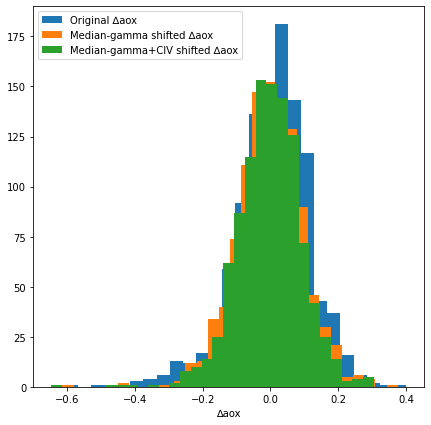

In [53]:
fig, ax1 = plt.subplots(figsize=(7,7))
ax1.hist(daox, bins="scott", label="Original ∆aox")
ax1.hist(daox_new, bins="scott", label="Median-gamma shifted ∆aox")
ax1.hist(daox_new2, bins="scott", label="Median-gamma+CIV shifted ∆aox")
ax1.set_xlabel("∆aox")
ax1.legend(loc="best")
plt.show()

Good -- this seems to have worked.

Now to correct the old $\alpha_{ox}$ values.

$$ \alpha_{ox,fit} = \alpha_{ox} - \Delta\alpha_{ox} $$

So the new $\alpha_{ox}$ value is 

$$ \alpha_{ox,new} = \alpha_{ox,old} - (\Delta\alpha_{ox,old} - \Delta\alpha_{ox,new}) $$

In [55]:
aox           = dat["Alpha_ox"].values #original aox values
aox_gamma     = aox - (daox - daox_new) #aox shifted based on gamma bins
aox_gamma_civ = aox - (daox - daox_new2) #aox shifted based on gamma and then CIV
L2500 = dat["L2500"].values

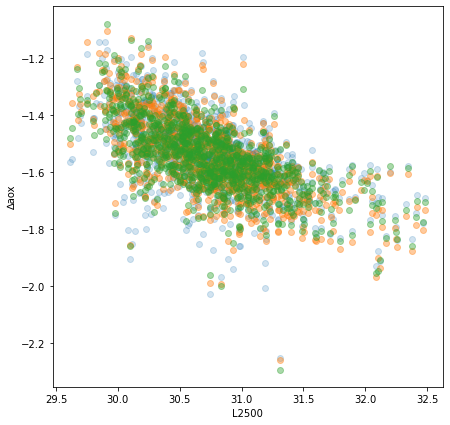

In [63]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(L2500, aox, alpha=0.2)
ax.scatter(L2500, aox_gamma, alpha=0.4)
ax.scatter(L2500, aox_gamma_civ, alpha=0.4)
ax.set_xlabel("L2500")
ax.set_ylabel("∆aox")
plt.show()

----

In [64]:
CIVdist.shape, gamma.shape

((1067,), (1067,))

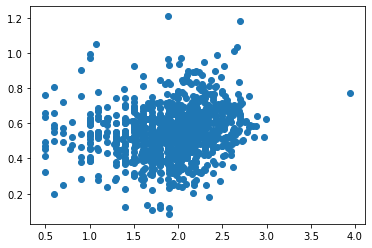

In [66]:
plt.scatter(gamma, CIVdist)

In [67]:
gamma_bins

array([0.5       , 0.72727273, 0.95454545, 1.18181818, 1.40909091,
       1.63636364, 1.86363636, 2.09090909, 2.31818182, 2.54545455,
       2.77272727, 3.        ])

In [68]:
median_civdist = []
for i in range(len(gamma_bins)-1):
    med_civdist = np.nanmedian(CIVdist[((gamma>=gamma_bins[i])&(gamma<=gamma_bins[i+1]))])
    median_civdist.append(med_civdist)    

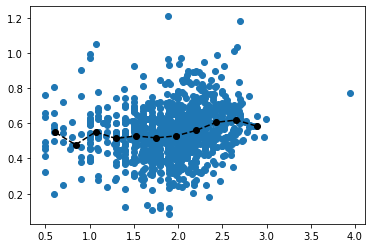

In [70]:
plt.scatter(gamma, CIVdist)
plt.plot(gamma_bins_plot, median_civdist, "--o", c="k")

In [71]:
plt.savefig?